In [11]:
# Full repository, etl pipelines, and architecture that I used to create the initial csv: https://github.com/x-ruiz/project-formula-1-wc-analytics
import pandas as pd
import dataframe_image as dfi
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor
from varname import varname

In [4]:
# Set Global Variables
gcp_project = "formula-1-wc-analytics"
# Function to export image in a separate thread
def export_df_image(dataframe, filename):
    dfi.export(dataframe, filename)

In [5]:
# EXTRACT|Prepped enriched csv from GCP BigQuery I created
def extract(filepath: str) -> pd.DataFrame:
    return pd.read_csv(filepath)

In [6]:
# CLEAN|Clean data type from string to bool
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df # this will create a pointer
    df_cleaned['won_home_race'] = df['won_home_race'].astype(bool)
    return df_cleaned

In [7]:
# TRANSFORM|Aggregations to identify the average home wins per driver per grand prix
def transform(df: pd.DataFrame) -> pd.DataFrame:
    df_agg_country = df_cleaned.copy(deep=True) # Deep copying here
    df_agg_country = df_agg_country.groupby(['country']).agg(
        num_races = ('race_id', 'count'),
        num_unique_winners = ('winner_driver', 'nunique'),
        num_home_wins = ('won_home_race', 'sum'), # We can use sum here because dtype=bool
        num_unique_home_winners = ('winner_driver', lambda x: (x[df.loc[x.index, 'won_home_race']].nunique())),
    )
    df_agg_country['avg_home_win_per_driver'] = round(df_agg_country['num_home_wins'] / df_agg_country['num_unique_home_winners'], 2)
    # Lets identify # of home wins by driver
    df_agg_driver = df_cleaned.copy(deep=True) # Deep copying here so as to not change original cleaned df when drilling
    df_agg_driver = df_agg_driver.groupby(['winner_driver', 'country']).agg( # winner_driver and country are now part of Multiindex
        num_home_wins = ('won_home_race', 'sum'),
    ).groupby(['country']).agg(
        max_home_wins = ('num_home_wins', 'max'),
        top_driver = ('num_home_wins', lambda x: 'none' if x.max() == 0 else x.idxmax()[0])
    ).sort_values(by='max_home_wins', ascending=False)
    # Join the two aggregated dfs
    df_joined = pd.merge(df_agg_country, df_agg_driver, left_on='country', right_on='country', how='inner')
    return df_joined

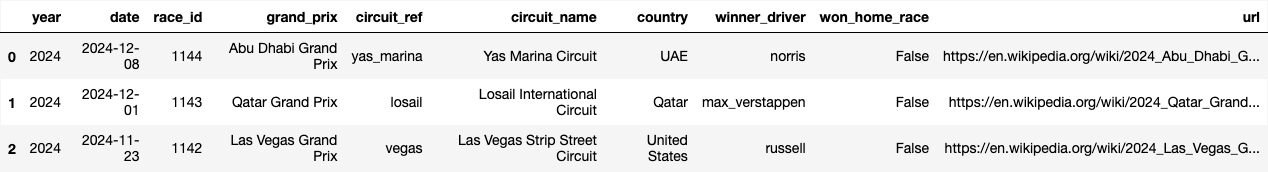

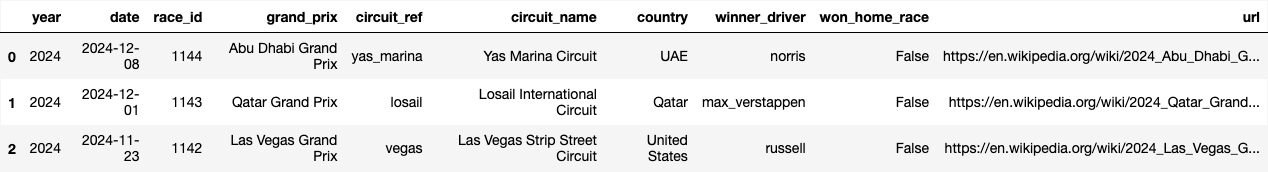

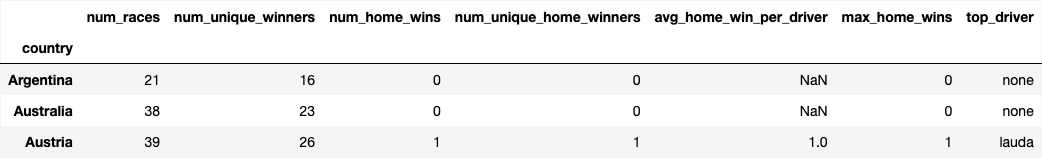

In [17]:
# PIPELINE|Execute functions in ETL fashion
df = extract("f1_data_enriched.csv")
df_cleaned = clean(df)
df_transformed = transform(df)
outputs = [(df, "df"), (df_cleaned, "df_cleaned"), (df_transformed, "df_transformed")]
with ThreadPoolExecutor() as executor: # handles enter and exit
    for i in outputs:
        future_df = executor.submit(export_df_image, i[0].head(3), f"{i[1]}.png")
        future_df.result() # Wait for the export to complete
        display(Image(f'{i[1]}.png'))

In [19]:
# Visualize
# 1. Is there correlation between a Countries GDP and # of races hosted?
# 2. Countries ranked by # of home wins vs Countries ranked by avg home wins per driver